In [1]:
# pip install keras_tuner

In [2]:
from pathlib import Path
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# %pip install scikit-learn
from sklearn.model_selection import train_test_split
from pathlib import Path
# %pip install matplotlib
import matplotlib.pyplot as plt
import glob
import random
from PIL import Image
import numpy as np

# Larger CNN Model
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Normalization
from keras.models import Model  # Import Model class
from keras.layers import Input, Dense, Flatten
from keras.optimizers import SGD  # Import optimizer if not already imported
from tensorflow.keras.layers import BatchNormalization
from sklearn import preprocessing
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.utils import plot_model

In [3]:
pixel = 37

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory='./Dataset for CA1 part A - AY2425S1/train', 
                                                                 color_mode='grayscale', 
                                                                 batch_size=10000,
                                                                 image_size=(pixel, pixel),
                                                                 seed = 42)

Found 9043 files belonging to 15 classes.


In [5]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory='./Dataset for CA1 part A - AY2425S1/test',
                                                                color_mode='grayscale',
                                                                batch_size=10000,
                                                                image_size=(pixel, pixel),
                                                                seed = 42)

Found 3000 files belonging to 15 classes.


In [6]:
valdation_data = tf.keras.preprocessing.image_dataset_from_directory(directory='./Dataset for CA1 part A - AY2425S1/validation',
                                                                        color_mode='grayscale',
                                                                        batch_size=10000,
                                                                        image_size=(pixel, pixel),
                                                                        seed = 42)

Found 3000 files belonging to 15 classes.


In [7]:
for image, label in train_data:
    X_train = image
    y_train = label

X_train = X_train/255
y_train = to_categorical(y_train,15)

In [8]:
for image, label in test_data:
    X_test = image
    y_test = label

X_test = X_test/255
y_test = to_categorical(y_test,15)

In [9]:
for image, label in valdation_data:
    X_validate = image
    y_validate = label

X_validate = X_validate/255
y_validate = to_categorical(y_validate,15)

In [10]:
print(X_validate.shape)
print(X_test.shape)
print(X_train.shape)    
print(y_train.shape)

(3000, 37, 37, 1)
(3000, 37, 37, 1)
(9043, 37, 37, 1)
(9043, 15)


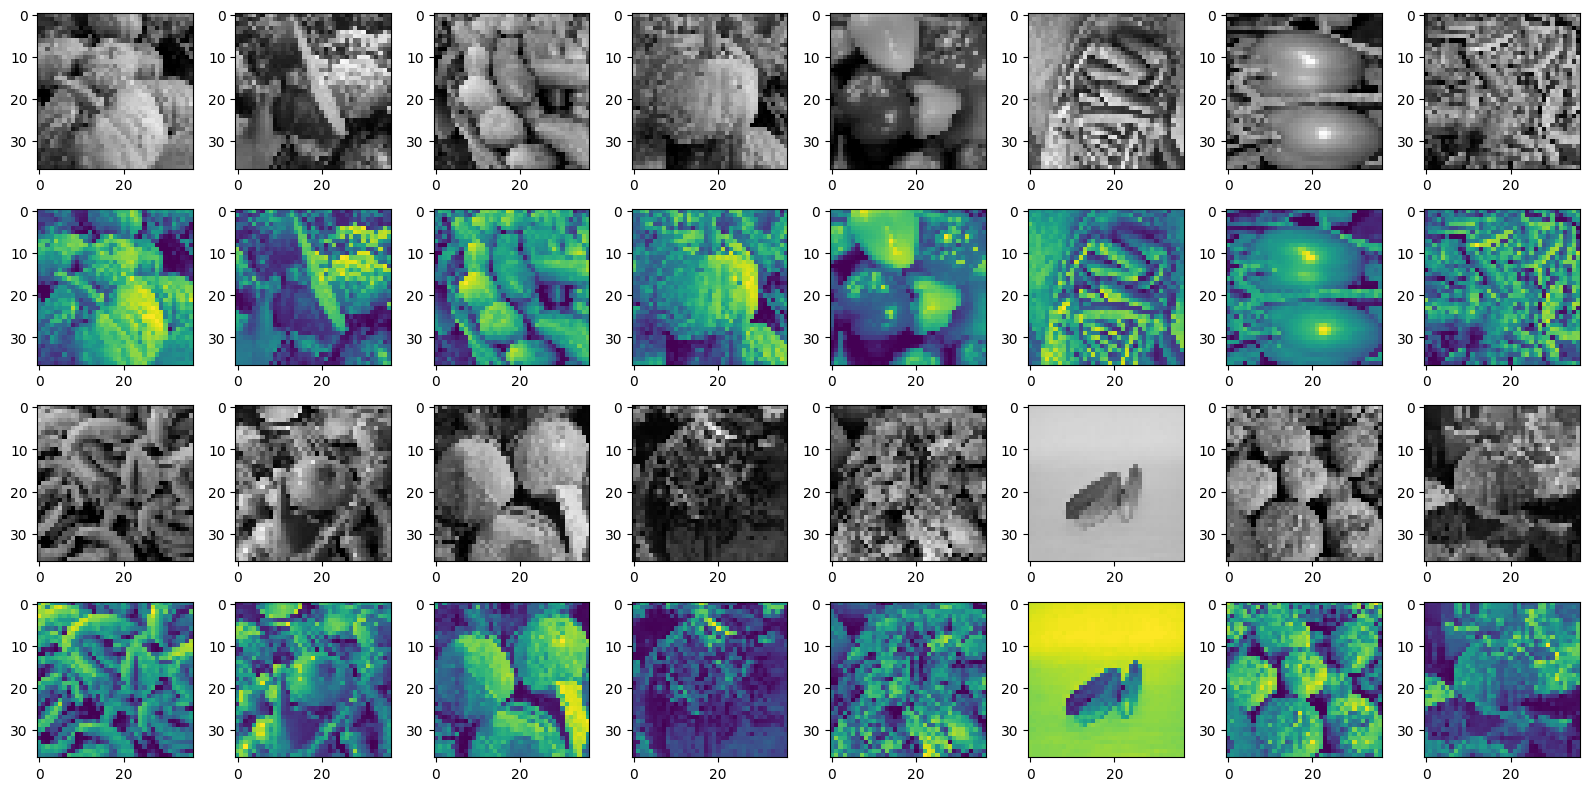

In [11]:
rows = 2 # defining number of rows in figure
cols = 8 # defining number of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2))

for i in range(rows):
    for j in range(cols):
        f.add_subplot(rows*2,cols,(2*i*cols)+(j+1))
        plt.imshow(tf.image.grayscale_to_rgb(X_train[i*cols + j]))
        plt.axis("on")

    for j in range(cols):
        f.add_subplot(rows*2,cols,((2*i+1)*cols) +(j+1))
        plt.imshow(X_train[i*cols + j])
        plt.axis("on")

plt.tight_layout()
plt.show()

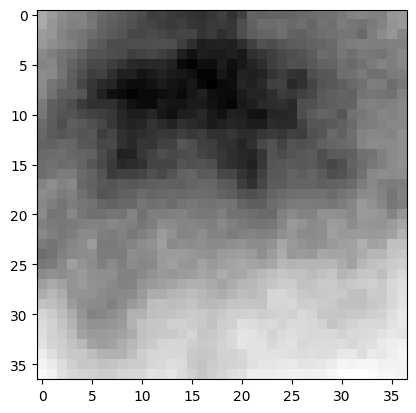

In [12]:
plt.imshow(np.mean(X_train, axis=0), cmap='Greys')
plt.show()

<Axes: >

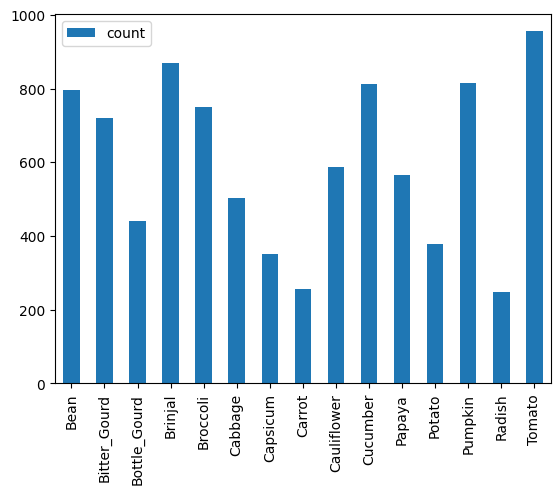

In [13]:
import pandas as pd
images_length={}
for i, cat in enumerate(os.listdir('./Dataset for CA1 part A - AY2425S1/train')):
        
        # Load images for the ith category
        image_path = "./Dataset for CA1 part A - AY2425S1/train" + '/' + cat
        images_in_folder = os.listdir(image_path)
        images_length[cat]=len(images_in_folder)
        
pd.DataFrame(images_length,index = ['count']).T.plot(kind='bar')

<h1>Utility Functions / Variable</h1>
<br>
<h3>Learning Curve Plotting Function</h3>

In [14]:
def plot_loss_curve(history):
    history = pd.DataFrame(history)
    epochs = list(range(1, len(history) + 1))
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    plt.title("Plot Loss Curve")
    plt.scatter(epochs, history["loss"])
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.scatter(epochs, history["val_loss"])
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.scatter(epochs, history["accuracy"])
    plt.plot(epochs, history["accuracy"], label="Training Accuracy")
    plt.scatter(epochs, history["val_accuracy"])
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

<h3>Model Results</h3>

In [15]:
# Initialize an empty DataFrame
Model_Results = pd.DataFrame()

# Assuming baseModelHistory is a dictionary with history data
def Update_Models(History,Name,Batch_size):
    global Model_Results
    History = History.history

    print(History)
    
    # Find the index of the best validation accuracy
    best_val_idx = np.argmax(History["val_accuracy"])

    # Result dictionary for the best epoch
    result = {
        'Model Name': Name,
        'epoch': len(History["loss"]),
        'Batch Size': Batch_size,
        'best_val_accuracy': History["val_accuracy"][best_val_idx],
        'best_val_loss': History["val_loss"][best_val_idx],
        'accuracy': History["accuracy"][best_val_idx],
        'loss': History["loss"][best_val_idx]
    }

    # Convert the result dictionary to a DataFrame and append it
    result_df = pd.DataFrame([result])
    Model_Results = pd.concat([Model_Results, result_df], ignore_index=True)

In [43]:
Batch_size = 64

In [17]:
num_classes = y_test.shape[1]

<H1>Data Augmentation</H1>

In [23]:
IMG_SIZE = (37, 37, 1)

In [24]:
def data_augmentation(x_train):
    imageArr = []
    for images in x_train:
        images = images.reshape(37, 37, 1)
        image = tf.image.random_flip_left_right(images)
        image = tf.image.resize_with_crop_or_pad(
            image, IMG_SIZE[0] + 4, IMG_SIZE[1])
        image = tf.image.random_crop(
            image, size=IMG_SIZE
        )
        imageArr.append(tf.reshape(image, (37, 37)))
    return np.array(imageArr)

In [25]:
X_train_aug = np.copy(X_train)

In [26]:
X_train_aug = data_augmentation(X_train_aug)

In [27]:
X_train_aug.shape

(9043, 37, 37)

In [28]:
print(X_train_aug.shape)

(9043, 37, 37)


In [29]:
class_labels = {0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}
classes = len(class_labels)

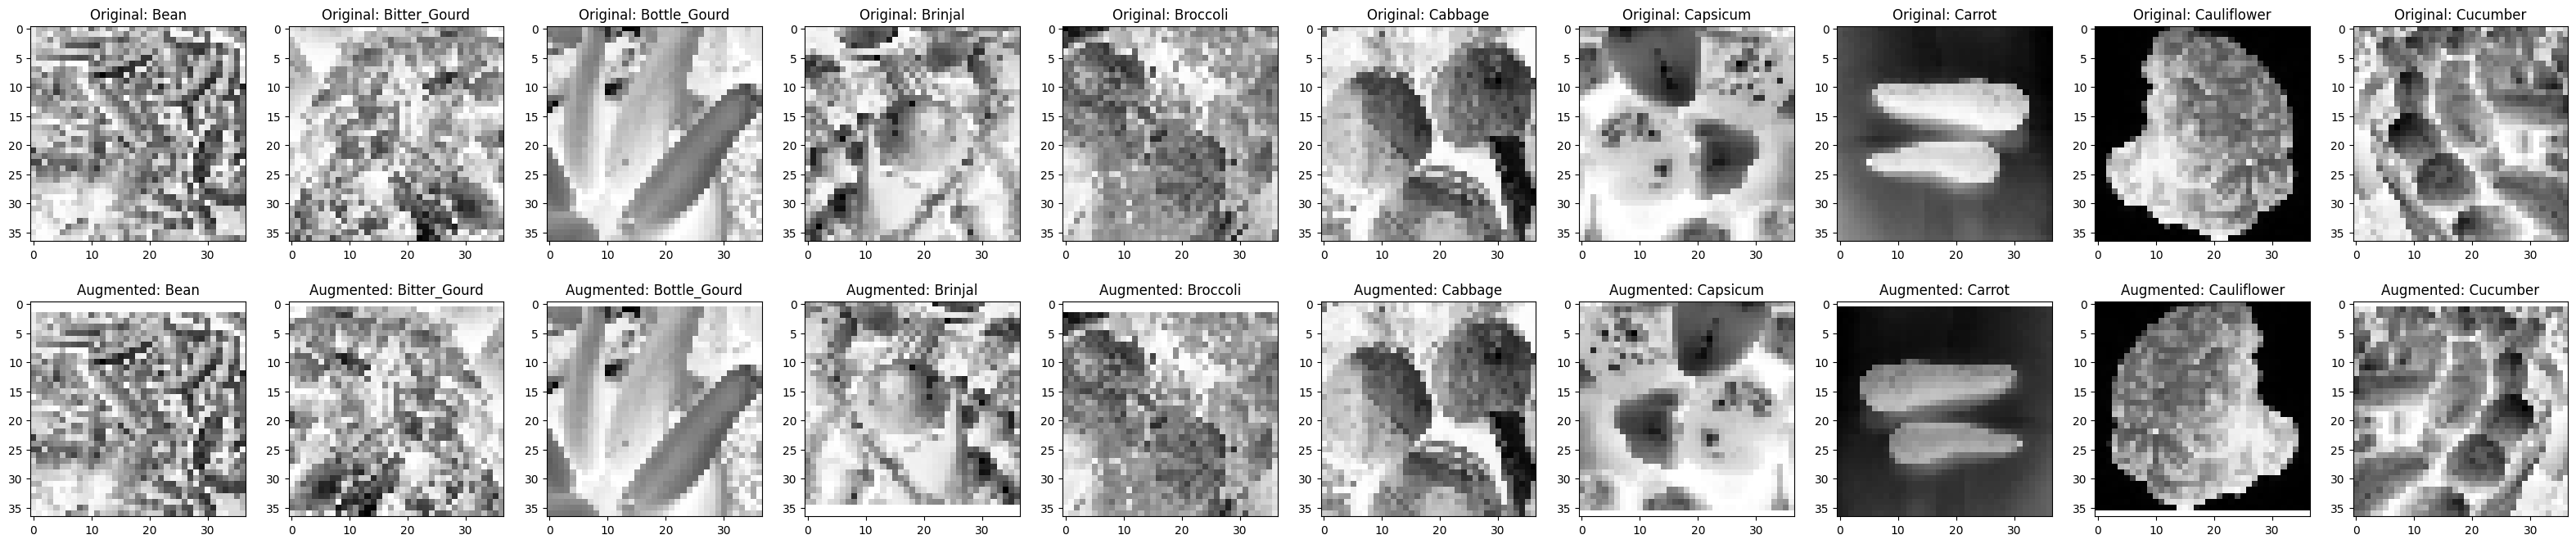

In [30]:
fig, ax = plt.subplots(2, 10, figsize=(40, 8))
for idx in range(20):
    subplot = ax.ravel()[idx]
    y_label = np.argmax(y_train, axis=1)
    if idx >= 10:
        subplot.set_title(f"Augmented: {class_labels[idx % 10]}")
        subplot.imshow(X_train_aug[y_label == idx % 10][0], cmap='Greys')
    else:
        subplot.set_title(f"Original: {class_labels[idx % 10]}")
        subplot.imshow(X_train[y_label == idx % 10][0], cmap='Greys')
    subplot.axis("on")
plt.show()

In [55]:
Input_Shape_37 = X_train.shape[1:]
Input_Shape_131 = None
print(Input_Shape_37)

(37, 37, 1)


# Models

### Baseline Fully Connected Neural Network

As our baseline model, we will be using it to compare against our other models that we are trying to build. This model will be very simple Model using the Sequential class and 3 types of hidden layers. For each hidden layer, we will be using the ReLU activation function and for the final output layer we will be using softmax as there is multiple classes. Sigmoid will not be usable. As there are multiple category that we are predicting, we will be using the categorical_crossentropy as our loss function.

##### Training baseline model without data augmentation
To train the baseline model, we will first use our unaugmented data to fit and train the model. Subsequently, we will use our augmented data to fit and train and compare the difference. We will start with the input size 37x37 followed by 131x131.

Baseline for 37 x 37:

In [58]:
def Baseline(x_train, model_name, input):
    # Create a new Sequential model
    baseline = Sequential(name=model_name)

    # Convolutional Layer
    baseline.add(Conv2D(32, (3, 3), input_shape=input, activation='relu'))
    # Pooling layer
    baseline.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature map
    baseline.add(Flatten())

    # Fully connected layers
    baseline.add(Dense(64, activation='relu'))
    baseline.add(Dropout(0.2))
    baseline.add(Dense(classes, activation='softmax'))

    # Compile the model
    baseline.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    baseline.summary()

    # Fit model with original 37x37 train dataset
    baseline_hist = baseline.fit(x_train, y_train, batch_size=Batch_size, validation_data=(X_validate,y_validate), epochs=50, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15))

    # save weights
    baseline.save_weights(f'Model_Weights/{model_name}_Weights.h5')

    # Save the entire model
    baseline.save(f'Model_Weights/{model_name}_Model.h5')

    from tensorflow.keras.utils import plot_model
    tf.keras.utils.plot_model(baseline, show_shapes=True)   

    scores = baseline.evaluate(X_test, y_test)
    print("CNN Error: %.2f%%" % (100 - scores[1] * 100))

    plot_loss_curve(baseline_hist.history)

    Update_Models(baseline_hist,model_name,Batch_size)

Baseline Model for 37 By 37 Pixels Non Augmented Data.

Model: "BaseLine_37x37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 35, 35, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 9248)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                591936    
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 15)                975       
                                                    

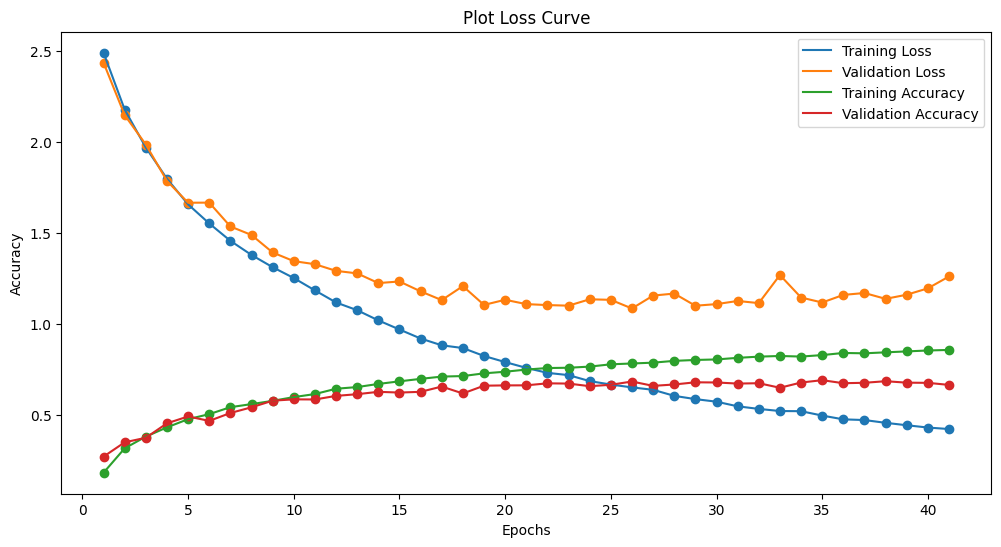

In [59]:
Baseline(X_train, 'BaseLine_37x37', Input_Shape_37)

<h2>Conv2D Model</h2>

<hr>
Without Augmented Data

Ref : https://www.geeksforgeeks.org/keras-conv2d-class/


<ol>
<li>kernel_size : This parameter determines the dimensions of the kernel. Common dimensions include 1×1, 3×3, 5×5, and 7×7 which can be passed as (1, 1), (3, 3), (5, 5), or (7, 7) tuples.
It is an integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.
This parameter must be an odd integer.</li>
</ol>

Simple CNN Model

In [45]:
SimpleConv = Sequential(name="SimpleConv2D")
SimpleConv.add(Conv2D(32,(5,5), activation='relu',input_shape = Input_Shape))
SimpleConv.add(MaxPooling2D(pool_size = (2,2)))
SimpleConv.add(Dropout(0.4))
SimpleConv.add(Flatten())
SimpleConv.add(Dense(128, activation='relu'))
SimpleConv.add(Dense(num_classes, activation='softmax'))
SimpleConv.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])

In [46]:
SimpleConv.summary()

Model: "SimpleConv2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 33, 33, 32)        832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_11 (Dense)            (None, 128)               1048704   
                                                                 
 dense_12 (Dense)            (None, 15)                1935      
                                                      

Epoch 1/100
142/142 [==============================] - 1s 8ms/step - loss: 2.5577 - accuracy: 0.1615 - val_loss: 2.6342 - val_accuracy: 0.1503
Epoch 2/100
142/142 [==============================] - 1s 5ms/step - loss: 2.2624 - accuracy: 0.2984 - val_loss: 2.2095 - val_accuracy: 0.3110
Epoch 3/100
142/142 [==============================] - 1s 6ms/step - loss: 1.9247 - accuracy: 0.4117 - val_loss: 1.8509 - val_accuracy: 0.4217
Epoch 4/100
142/142 [==============================] - 1s 5ms/step - loss: 1.6230 - accuracy: 0.4900 - val_loss: 1.6222 - val_accuracy: 0.5097
Epoch 5/100
142/142 [==============================] - 1s 5ms/step - loss: 1.3770 - accuracy: 0.5704 - val_loss: 1.4560 - val_accuracy: 0.5357
Epoch 6/100
142/142 [==============================] - 1s 5ms/step - loss: 1.1700 - accuracy: 0.6441 - val_loss: 1.2675 - val_accuracy: 0.6007
Epoch 7/100
142/142 [==============================] - 1s 5ms/step - loss: 1.0076 - accuracy: 0.6864 - val_loss: 1.1236 - val_accuracy: 0.6553

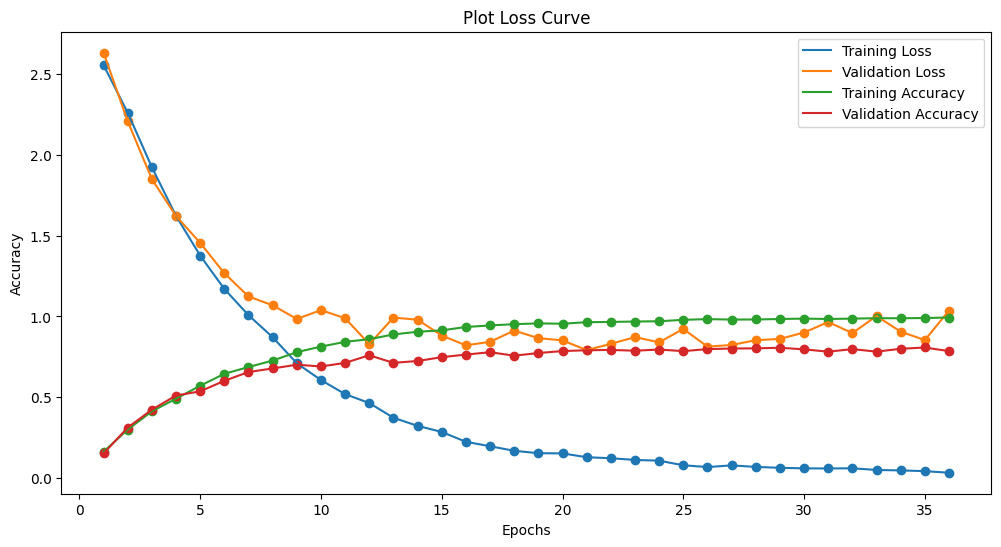

In [40]:
SimpleConv2DHistory = SimpleConv.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=100, batch_size=64, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True))
Update_Models(SimpleConv2DHistory,SimpleConv.name,100)
plot_loss_curve(SimpleConv2DHistory.history)

Epoch 1/100
142/142 [==============================] - 1s 6ms/step - loss: 2.5882 - accuracy: 0.1373 - val_loss: 2.6008 - val_accuracy: 0.1467
Epoch 2/100
142/142 [==============================] - 1s 5ms/step - loss: 2.3698 - accuracy: 0.2357 - val_loss: 2.5390 - val_accuracy: 0.2090
Epoch 3/100
142/142 [==============================] - 1s 5ms/step - loss: 2.1602 - accuracy: 0.3086 - val_loss: 2.1266 - val_accuracy: 0.2840
Epoch 4/100
142/142 [==============================] - 1s 5ms/step - loss: 1.9304 - accuracy: 0.3811 - val_loss: 2.0998 - val_accuracy: 0.3440
Epoch 5/100
142/142 [==============================] - 1s 5ms/step - loss: 1.6996 - accuracy: 0.4553 - val_loss: 1.6976 - val_accuracy: 0.4680
Epoch 6/100
142/142 [==============================] - 1s 5ms/step - loss: 1.5180 - accuracy: 0.5092 - val_loss: 2.0191 - val_accuracy: 0.3913
Epoch 7/100
142/142 [==============================] - 1s 5ms/step - loss: 1.3510 - accuracy: 0.5674 - val_loss: 1.5948 - val_accuracy: 0.4753

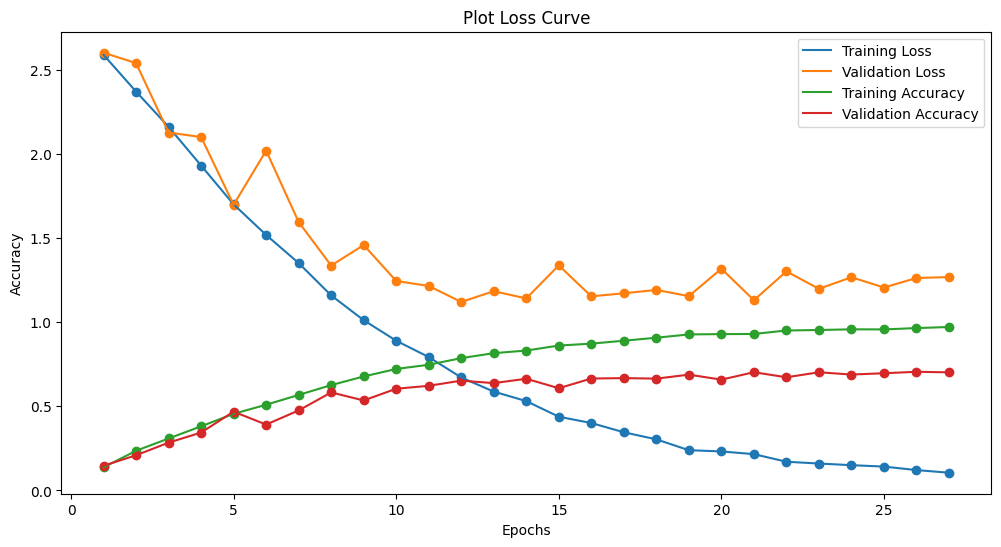

In [47]:
SimpleConv2DHistory = SimpleConv.fit(X_train_aug, y_train, validation_data=(X_validate, y_validate), epochs=100, batch_size=64, verbose=1, callbacks=EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True))
Update_Models(SimpleConv2DHistory,SimpleConv.name,100)
plot_loss_curve(SimpleConv2DHistory.history)

In [41]:
Model_Results

,Model Name,epoch,Batch Size,best_val_accuracy,best_val_loss,accuracy,loss
0,BaseLine,42,32,0.473667,0.212468,0.754064,0.092473
1,SimpleConv2D,25,100,0.790667,1.085911,0.994913,0.019486
2,SimpleConv2D,17,100,0.793333,0.992834,0.996461,0.017171
3,SimpleConv2D,36,100,0.807333,0.853334,0.990048,0.040907


In [42]:
SimpleConv2D = Sequential(name="Conv2D - 2CNN 2Dense")

SimpleConv2D.add(Conv2D(32,(5,5), activation='relu',input_shape = Input_Shape))
SimpleConv2D.add(MaxPooling2D(pool_size = (2,2)))
SimpleConv2D.add(Conv2D(32,(5,5), activation='relu'))
SimpleConv2D.add(MaxPooling2D(pool_size = (2,2)))

SimpleConv2D.add(Dropout(0.2))
SimpleConv2D.add(Flatten())
SimpleConv2D.add(Dense(128, activation='relu'))
SimpleConv2D.add(Dense(64, activation='relu'))
SimpleConv2D.add(Dense(num_classes, activation='softmax'))
SimpleConv2D.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), metrics=['accuracy'])

In [73]:
def conv2D_Model(x_train,loss_type,activation_type,Batch_size):
    conv2D = Sequential()

    conv2D.add(Conv2D(32,(5,5), padding="same", activation='relu',input_shape = X_train.shape[1:]))
    conv2D.add(MaxPooling2D(pool_size=(2,2)))

    conv2D.add(Conv2D(64,(3, 3), activation=activation_type))
    conv2D.add(MaxPooling2D(pool_size=(2, 2)))

    conv2D.add(Conv2D(128,(3, 3), activation=activation_type))
    conv2D.add(MaxPooling2D(pool_size=(2, 2)))

    conv2D.add(Dropout(0.3))
    conv2D.add(Flatten())

    conv2D.add(BatchNormalization())
    
    conv2D.add(Dense(256, activation = activation_type)) 
    conv2D.add(Dense(128, activation = activation_type)) 
    conv2D.add(Dense(84, activation = activation_type)) 
    conv2D.add(Dense(64, activation = activation_type)) 

    conv2D.add(Dense(num_classes, activation ='softmax')) 

    conv2D.compile(loss=loss_type,
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                metrics=['accuracy'])

    # mon_val_acc = EarlyStopping(monitor='val_accuracy', patience=15)
    mon_val_loss = EarlyStopping(monitor='val_loss', patience=15)

    train_history = conv2D.fit(x_train, y_train, validation_data=(X_validate, y_validate), epochs=100, batch_size=Batch_size, verbose=1, callbacks = mon_val_loss)

    # Final evaluation of the model
    scores = conv2D.evaluate(X_test, y_test)
    print("CNN Error: %.2f%%" % (100 - scores[1] * 100))

    plot_loss_curve(train_history.history)

    # plot_model(conv2D)

    return train_history,loss_type,activation_type

Epoch 1/100
91/91 [==============================] - 4s 39ms/step - loss: 2.6905 - accuracy: 0.0945 - val_loss: 2.7061 - val_accuracy: 0.0730
Epoch 2/100
91/91 [==============================] - 3s 36ms/step - loss: 2.6219 - accuracy: 0.1236 - val_loss: 2.7038 - val_accuracy: 0.0863
Epoch 3/100
91/91 [==============================] - 3s 37ms/step - loss: 2.5681 - accuracy: 0.1519 - val_loss: 2.6886 - val_accuracy: 0.1267
Epoch 4/100
91/91 [==============================] - 3s 36ms/step - loss: 2.4935 - accuracy: 0.1973 - val_loss: 2.6478 - val_accuracy: 0.1183
Epoch 5/100
91/91 [==============================] - 3s 36ms/step - loss: 2.3892 - accuracy: 0.2336 - val_loss: 2.5630 - val_accuracy: 0.1523
Epoch 6/100
91/91 [==============================] - 3s 37ms/step - loss: 2.2785 - accuracy: 0.2707 - val_loss: 2.3749 - val_accuracy: 0.2387
Epoch 7/100
91/91 [==============================] - 3s 37ms/step - loss: 2.1608 - accuracy: 0.3128 - val_loss: 2.3377 - val_accuracy: 0.2430
Epoch 

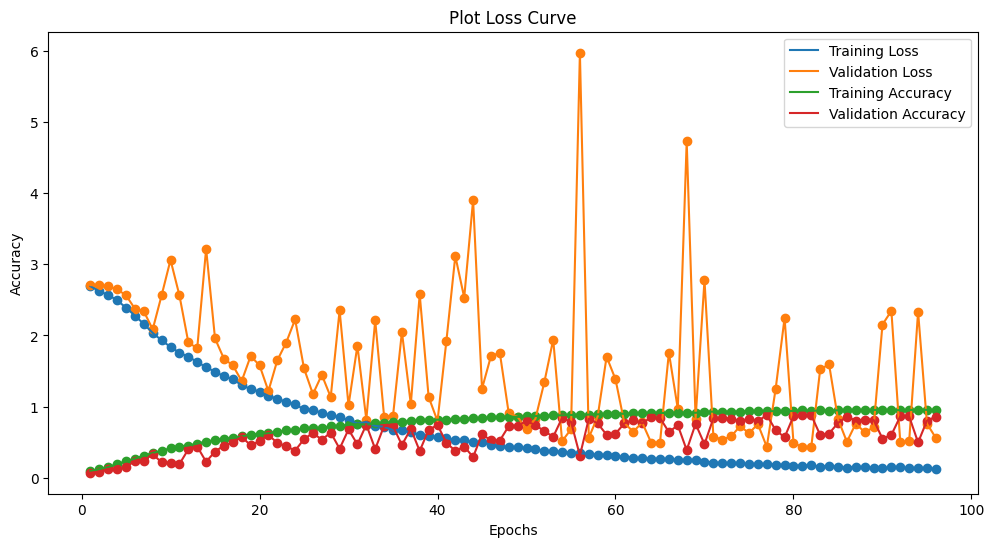

In [74]:
from tensorflow.keras.layers import AveragePooling2D

histories = []
loss = [tf.keras.losses.categorical_crossentropy]
activation = ['relu']
for i in loss:
    for x in activation:
        Model_Hist,Loss,Activation = conv2D_Model(X_train,i,x,100)
        histories.append((Model_Hist,Loss,Activation))
        Update_Models(Model_Hist,f'Con2D + {x}',100)

In [75]:
# for history_info in histories:
#     print(f'Activation: {history_info[2]} \nLoss: {str(history_info[1])}\n')
#     print(history_info[0].history)
#     print("-" * 225)

In [76]:
Model_Results

,Model Name,epoch,Batch Size,best_val_accuracy,best_val_loss,accuracy,loss
0,BaseLine,29,32,0.471667,0.180167,0.642707,0.124600
1,Con2D + relu,96,100,0.882000,0.435729,0.936525,0.193335


With Augmented Data

Epoch 1/100
91/91 [==============================] - 3s 18ms/step - loss: 2.6950 - accuracy: 0.0909 - val_loss: 2.7056 - val_accuracy: 0.0767
Epoch 2/100
91/91 [==============================] - 1s 14ms/step - loss: 2.6101 - accuracy: 0.1210 - val_loss: 2.7008 - val_accuracy: 0.0950
Epoch 3/100
91/91 [==============================] - 1s 13ms/step - loss: 2.5336 - accuracy: 0.1610 - val_loss: 2.6748 - val_accuracy: 0.1583
Epoch 4/100
91/91 [==============================] - 1s 14ms/step - loss: 2.4401 - accuracy: 0.1969 - val_loss: 2.6350 - val_accuracy: 0.1340
Epoch 5/100
91/91 [==============================] - 1s 14ms/step - loss: 2.3425 - accuracy: 0.2292 - val_loss: 2.4967 - val_accuracy: 0.2107
Epoch 6/100
91/91 [==============================] - 1s 14ms/step - loss: 2.2573 - accuracy: 0.2522 - val_loss: 2.3654 - val_accuracy: 0.2647
Epoch 7/100
91/91 [==============================] - 1s 14ms/step - loss: 2.1604 - accuracy: 0.2922 - val_loss: 2.2951 - val_accuracy: 0.2383
Epoch 

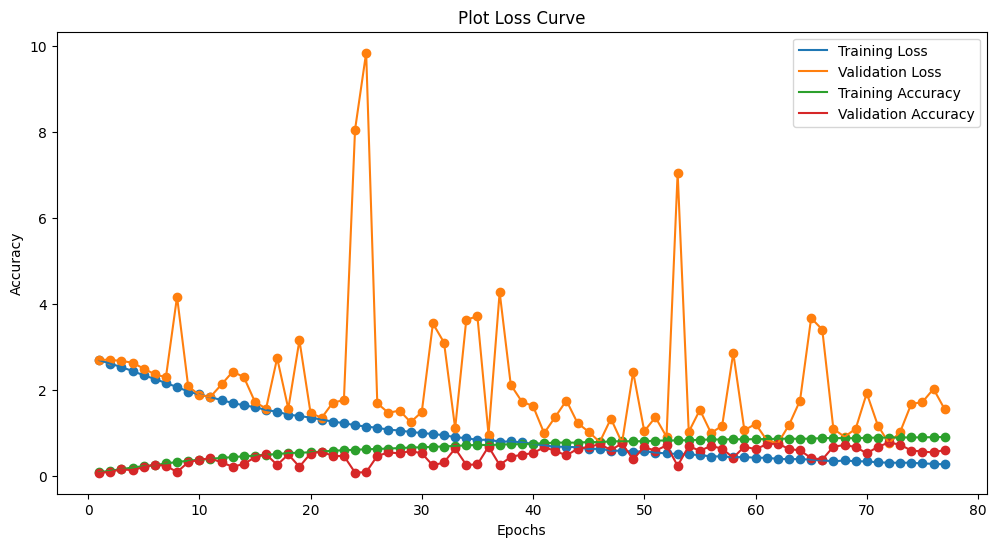

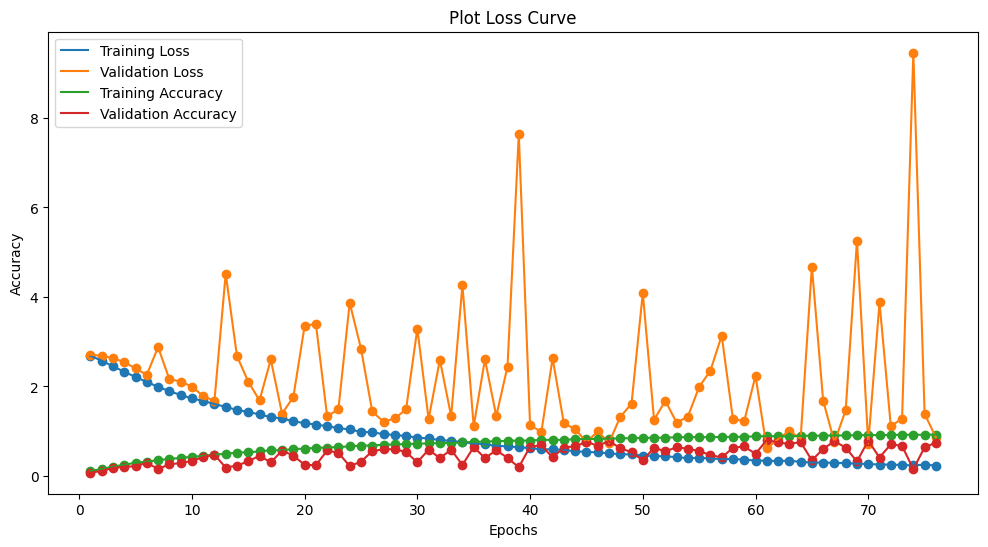

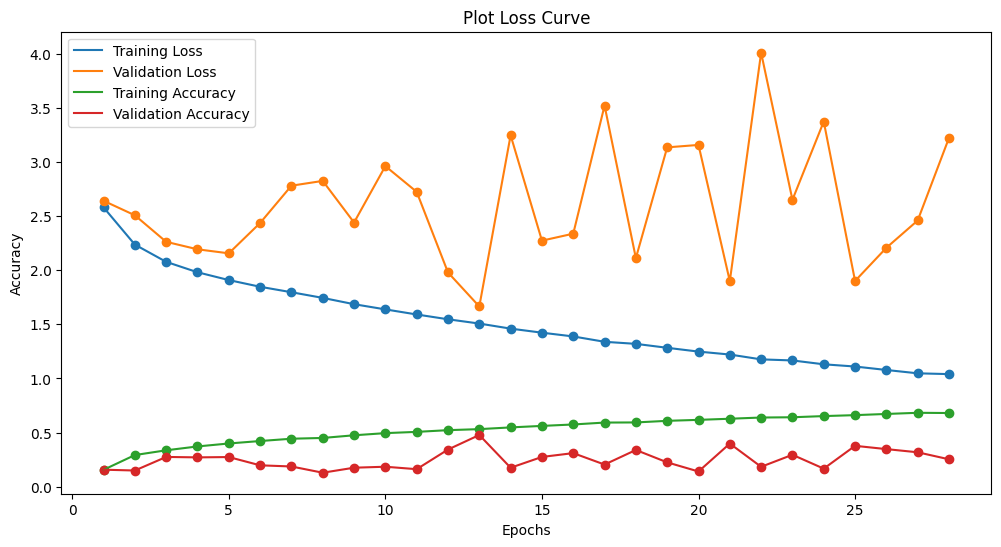

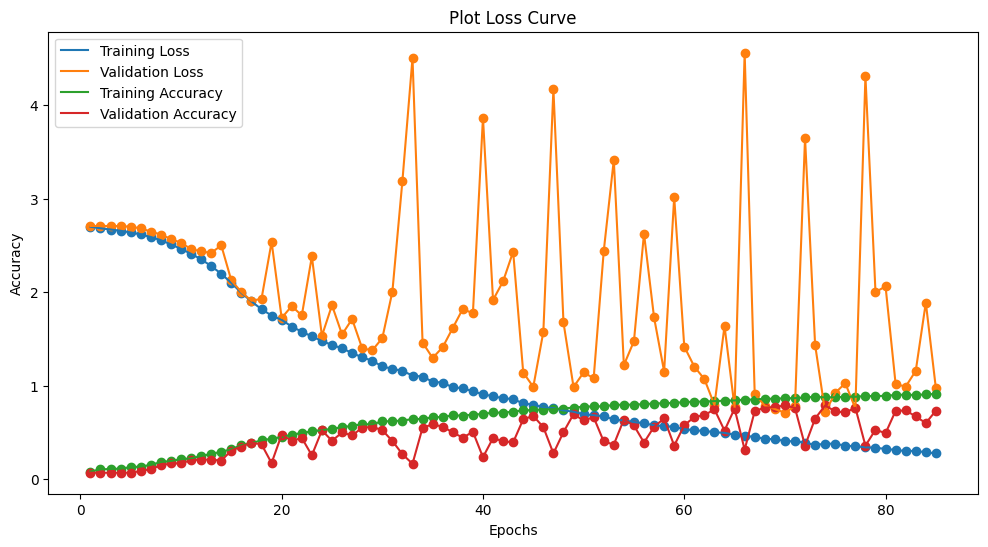

In [77]:
loss = [tf.keras.losses.categorical_crossentropy]
activation = ['relu','leaky_relu','tanh','gelu']
for i in loss:
    for x in activation:
        Model_Hist,Loss,Activation = conv2D_Model(X_train_aug,i,x,100)
        histories.append((Model_Hist,Loss,Activation))
        Update_Models(Model_Hist,f'Con2D + {x} (Augmented Data)',100)

In [78]:
Model_Results

,Model Name,epoch,Batch Size,best_val_accuracy,best_val_loss,accuracy,loss
0,BaseLine,29,32,0.471667,0.180167,0.642707,0.124600
1,Con2D + relu,96,100,0.882000,0.435729,0.936525,0.193335
2,Con2D + relu (Augmented Data),77,100,0.780000,0.763047,0.894504,0.309492
3,Con2D + leaky_relu (Augmented Data),76,100,0.805333,0.614681,0.889196,0.341485
4,Con2D + tanh (Augmented Data),28,100,0.478333,1.664893,0.532456,1.507139
5,Con2D + gelu (Augmented Data),85,100,0.787333,0.709462,0.863983,0.403888


In [163]:
from tensorflow import keras
from keras_tuner import HyperModel

num_classes = 15  # Example number of classes

class MyHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        
        # Input layer and first convolutional layer
        model.add(keras.layers.Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            input_shape=(37, 37, 1)
        ))
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        
        # Adding additional convolutional layers
        for i in range(1, hp.Int('num_conv_layers', 1, 5)):
            model.add(keras.layers.Conv2D(
                filters=hp.Int(f'conv_{i+1}_filter', min_value=32, max_value=128, step=16),
                kernel_size=hp.Choice(f'conv_{i+1}_kernel', values=[3, 5]),
                activation='relu'
            ))
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        
        model.add(keras.layers.Flatten())
        
        model.add(BatchNormalization())

        # Adding variable number of dense layers
        for i in range(hp.Int('num_dense_layers', 1, 5)):
            model.add(keras.layers.Dense(
                units=hp.Int(f'dense_{i+1}_units', min_value=32, max_value=128, step=16),
                activation='relu'
            ))
        
        # Output layer
        model.add(keras.layers.Dense(num_classes, activation='softmax'))
        
        # Compilation of the model

        for i in ['categorical_crossentropy']:
            model.compile(
                optimizer=keras.optimizers.SGD(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss=i,
                metrics=['accuracy']
            )
        
        return model

# Example usage with Keras Tuner
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=5,
    directory='CNN',
    project_name='RandomSearch 2' 
)

Reloading Tuner from CNN\RandomSearch 2\tuner0.json


In [164]:
tuner.search(X_train_aug, y_train, epochs=100 ,batch_size = 100,validation_data=(X_validate, y_validate),callbacks=[EarlyStopping(monitor='val_loss', patience=15)])

Trial 15 Complete [00h 17m 05s]
val_accuracy: 0.5552000045776367

Best val_accuracy So Far: 0.7067333340644837
Total elapsed time: 01h 48m 03s


In [178]:
import winsound
import time
for i in (0,10):
    winsound.Beep(1000, 5000)
    time.sleep(1)


In [171]:
tuner.reload()

# Extract and print the accuracy results from each trial
for trial in tuner.oracle.get_best_trials(num_trials=11):
    val_accuracy = trial.metrics.get_best_value('val_accuracy')
    print(f'Trial ID: {trial.trial_id}, Best Validation Accuracy: {val_accuracy}')


Trial ID: 07, Best Validation Accuracy: 0.7067333340644837
Trial ID: 00, Best Validation Accuracy: 0.6869999885559082
Trial ID: 12, Best Validation Accuracy: 0.6597999930381775
Trial ID: 02, Best Validation Accuracy: 0.6577333450317383
Trial ID: 11, Best Validation Accuracy: 0.5597999930381775
Trial ID: 01, Best Validation Accuracy: 0.5565333306789398
Trial ID: 14, Best Validation Accuracy: 0.5552000045776367
Trial ID: 09, Best Validation Accuracy: 0.5420666635036469
Trial ID: 06, Best Validation Accuracy: 0.4678666710853577
Trial ID: 10, Best Validation Accuracy: 0.4518666625022888
Trial ID: 03, Best Validation Accuracy: 0.3197999894618988


In [ ]:
# Instantiate an empty sequential model
model = Sequential()
# C1 Convolutional Layer
model.add(Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'tanh', 
input_shape = (37,37,1), padding = 'same'))

# S2 Pooling Layer
model.add(AveragePooling2D(pool_size = 2, strides = 2, padding = 'valid'))

# C3 Convolutional Layer
model.add(Conv2D(filters = 16, kernel_size = 5, strides = 1,activation = 'tanh',
                padding = 'valid'))
# S4 Pooling Layer
model.add(AveragePooling2D(pool_size = 2, strides = 2, padding = 'valid'))

# C5 Convolutional Layer
model.add(Conv2D(filters = 120, kernel_size = 5, strides = 1,activation = 'tanh',
                padding = 'valid'))

# Flatten the CNN output to feed it with fully connected layers
model.add(Flatten())

# FC6 Fully Connected Layer
model.add(Dense(units = 84, activation = 'tanh'))

# FC7 Output layer with softmax activation
model.add(Dense(units = 15, activation = 'softmax'))

# print the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 37, 37, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 18, 18, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 7, 7, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_17 (Conv2D)          (None, 3, 3, 120)         48120     
                                                                 
 flatten_6 (Flatten)         (None, 1080)             

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01),
               metrics=['accuracy'])

c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
hist = model.fit(X_train_aug, y_train, batch_size=32, epochs=100,
           validation_data=(X_validate, y_validate), callbacks=EarlyStopping(monitor='val_loss', patience=15),
           verbose=2, shuffle=True)

Epoch 1/100
283/283 - 2s - loss: 2.6354 - accuracy: 0.1115 - val_loss: 2.7650 - val_accuracy: 0.1000 - 2s/epoch - 7ms/step
Epoch 2/100
283/283 - 1s - loss: 2.5946 - accuracy: 0.1477 - val_loss: 2.7035 - val_accuracy: 0.1257 - 1s/epoch - 4ms/step
Epoch 3/100
283/283 - 1s - loss: 2.4830 - accuracy: 0.1902 - val_loss: 2.5409 - val_accuracy: 0.1723 - 1s/epoch - 4ms/step
Epoch 4/100
283/283 - 1s - loss: 2.3767 - accuracy: 0.2313 - val_loss: 2.4659 - val_accuracy: 0.2217 - 1s/epoch - 5ms/step
Epoch 5/100
283/283 - 1s - loss: 2.3351 - accuracy: 0.2545 - val_loss: 2.4835 - val_accuracy: 0.2127 - 1s/epoch - 5ms/step
Epoch 6/100
283/283 - 1s - loss: 2.3022 - accuracy: 0.2681 - val_loss: 2.4079 - val_accuracy: 0.2333 - 1s/epoch - 5ms/step
Epoch 7/100
283/283 - 1s - loss: 2.2652 - accuracy: 0.2777 - val_loss: 2.3902 - val_accuracy: 0.2413 - 1s/epoch - 4ms/step
Epoch 8/100
283/283 - 1s - loss: 2.2310 - accuracy: 0.2866 - val_loss: 2.3460 - val_accuracy: 0.2583 - 1s/epoch - 4ms/step
Epoch 9/100
283/